# Imports

In [1]:
import pandas as pd                       # data processing
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np                        # linear algebra
import datetime as dt                     # datetime manipulation

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score

from joblib import load, dump

C:\Users\btros\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Functions

In [2]:
def reduce_features(df):
    cols = ['X', 'Y', 'incident_id', 'oid']
    
    df = df.drop(columns=cols)
    
    return df

def drop_null_cols(df):
    
    columns_with_null = df.isnull().sum().sort_values(ascending=False)[:9].index.tolist()
    df = df.drop(columns=columns_with_null)
    
    return df

def extract_timestamp_feats(df, column):
    
    # Cast the column to DateTime type
    df[column] = pd.to_datetime(df[column])
    
    # Extract date related features
    df['call_year']  = df[column].dt.year
    df['call_month'] = df[column].dt.month
    df['call_day']   = df[column].dt.day
    df['call_dow']   = df[column].dt.dayofweek
    df['call_week']  = df[column].dt.week
    
    # Extract time related features
    df['call_hour']   = df[column].dt.hour
    df['call_minute'] = df[column].dt.minute
    """
    Extacts the time of day from the hour value by dividing by the hour knife
    1 = Morning  (0400 - 1000h)
    2 = Midday   (1000 - 1600h)
    3 = Evening  (1600 - 2200h)
    4 = Night    (2200 - 0400h)
    """    
    hour_knife = 6
    df['part_of_day'] = ((df['call_hour'] + 2) / hour_knife).astype(int)
    df['part_of_day'] = df['part_of_day'].replace(0, 4)
    
    # Drop the now redundant column
    df = df.drop(columns=column)
    
    return df

def filter_geo_outliers(df):
    """
    Filters out the outliers in the data where the latitude and longitudes 
    exist outside the geographic limits of the city of Detroit
    """    
    n_bound =  42.46
    e_bound = -82.91
    s_bound =  42.25
    w_bound = -83.28
    
    #  Retains only those observations within the geographic boundaries
    df = df.loc[((df['longitude'] > w_bound) & (df['longitude'] < e_bound)) &
                ((df['latitude'] > s_bound) & (df['latitude'] < n_bound ))]
    
    return df 

def plot_lat_lon(df):
    
    fig, ax = plt.subplots(figsize=(12, 8))
#     img = plt.imread(r"C:\Users\btros\Downloads\detroit_map.jpg")
#     ax.imshow(img)
    ax = sns.scatterplot(data=df, x='longitude', y='latitude', alpha=0.1)
#     ax = sns.scatterplot(x=[1,2,3], y=[2,4,6], alpha=0.1)
    ax.set_facecolor('.2')
    fig.set_facecolor('.2')
    
    return plt.show();

def remove_categoricals(df):
    unneeded = df.select_dtypes(exclude="number").nunique().index.tolist()
    unneeded.remove('calldescription')

    df = df.drop(columns=unneeded)
    
    return df

def clean_observations(df):    
    """
    Removing observations where the call description
    is not related to emergency services
    """
    col = 'calldescription'
    
    unrelated_calls = ['START OF SHIFT INFORMATION', 'CALL BACK DESK', 'REMARKS',
                      'EMPLOYEE CALL IN / TIME OFF', 'NOTIFICATION(S) MADE',
                      'TIBURON HISTORICAL DATE', 'BLUE LIGHT PHONE MALF']
    
    for call in unrelated_calls:
        df = df.loc[df[col] != call]
    
    return df

def filter_calldescription(df, col='calldescription'):
    
    #  List of call descriptions according to which service responded
    
    police = ['TRAFFIC STOP', 'SPECIAL ATTENTION', 'DISTURBANCE', 'INVESTIGATE PERSON',
              'ASSAULT AND BATTERY', 'UNKNOWN PROBLEM', 'TOWING DETAIL', 'FELONIOUS ASSAULT IP',
              'LARCENY REPORT', 'AUTO X UNK INJ / IMPAIRED', 'BUS BOARDING', 'PERSON WITH WEAPON',
              'VERIFIED ALR / PERSON W/O CODE', 'UDAA REPORT', 'BURGLARY OCCUPIED RESD I/P',
              'SHOTS FIRED IP', 'INVESTIGATE AUTO', 'MALICIOUS DESTRUCTION I/P', 'MISCELLANEOUS TRAFFIC',
              'PANIC / DURESS ALARM', 'FRAUD REPORT', 'BUILDING CHECK', 'VICIOUS ANIMAL', 'LARCENY I/P OR J/H',
              'THREATS REPORT', 'RECOVER AUTO', 'HOLD UP ALARM AND MOW', 'MALICIOUS DESTRUCTION RPT', 
              'BURGLARY OTHER', 'PARKING COMPLAINT', 'WELL BEING CHECK', 'MENTAL VIOLENT NOT ARMED',
              'ASSIST OTHER', 'INFORMATION/NON-CRIMINAL RPT', 'ASSAULT AND BATTERY REPORT', 'AUTO X REPORT',
              'BURGLARY OCCUPANT AWAY I/P', 'MISSING REPORT',  'NARCOTICS I/P', 'BURGLARY RESIDENCE REPORT',
              'MISSING SERIOUS', 'ALARM UNKNOWN CAUSE', 'SUICIDE THREAT', 'CHILD /  ADULT ABUSE',  'WNTD WRRNT FELONY',
              'ADMIT OR E/E', 'FELONIOUS ASSAULT JH', 'ASSIST CITIZEN', 'SPECIAL ATTENTION / DETAIL', 'DEAD PERSON OBSERVED',
              'LOST PROPERTY', 'SUICIDE I/P', 'TRANSPORT PRISONER', 'ROBBERY ARMED IP-ANY', 'RECOVERED / FOUND PROPERTY',
              'SAFEWALK', 'CHILD / ADULT ABUSE REPORT', 'BREAKING AND ENTERING AUTO I/P', 'FELONIOUS ASSAULT REPORT',
              'RAID - EXECUTE SEARCH WARRANT', 'MENTAL VIOLENT - ARMED', 'RAPE REPORT', 'HARASSMENT REPORT',
              'BURGLARY BUSINESS IP', 'KIDNAPPING', 'PPO VIOLATION I/P', 'LEWD AND LASCIVIOUS IP', 'AID MOTORIST / CHILD LOCKED IN',
              'BREAKING & ENTERING AUTO RPT', 'DV A/B I/P-J/H', 'ROBBERY NOT ARMED I/P', 'SQUATTER DISTURBANCE',
              'SCRAP STRIP  BLDG  IP', 'ASSAULT AND BATTERY I/P', 'AUTO OR PED H&R REPORT', 'FRAUD I/P',
              'AUTO X HIT & RUN W/ INJ', 'BURGLARY OCCUP RESD REPT', 'RUBBISH LITTERING I/P', 'SHOTS J/H, EVIDENCE, REPT',
              'BE ON THE LOOK OUT', 'SHOOTING/CUTTING/PENT WND RPT', 'HOLDING PERSON', 'ARSON I/P', 'BURGLARY OTHER REPORT',
              'ANIMAL COMPLAINT', 'ARSON REPORT', 'ASSIST PERSONNEL', 'ROBBERY ARMED REPORT', 'VERIFY RETURN OF MISSING',
              'DDOT TROUBLE', 'WNTD WRRNT MISDEMEANOR', 'ROBBERY ARMED JH-ANY WEAPON',  'BURGLARY OCCUPANT AWAY J/H',
              'UDAA I/P', 'SCHOOL CROSSING', 'HAZARDOUS CONDITIONS', 'SENIOR CITIZEN ASSIST', 'ROBBERY NOT ARMED REPORT',
              'ONE OVER THE WHEEL', 'RAPE IP OR JH', 'PROPERTY DAMAGE NON-CRIMINAL', 'PEACE OFFICER DETAIL', 'BURGLARY BUSINESS REPORT',
              'BURGLARY BUSINESS J/H', 'CHILD(REN) HOME ALONE', 'DV F/A I/P-J/H', 'ESCORT', 'NARCOTICS REPORT', 'AID MOTORIST MISC',
              'PPO VIOLATION REPORT', 'RECOVER AUTO FELONY', 'LEWD AND LASCIVIOUS','VEHICLE FIRE', 'NOISE COMPLAINT', 
              'FOUND PERSON', 'MOLESTATION REPORT', 'PBT TEST', 'RESIDENTIAL STRUCTURE FIRE', 'ASSIST REF GAINING ENTRY',
              'ATM  ALARM',  'WSPD - BURGLARY ALR', 'ALTERED LOC OR UNK PROBLEM', 'PAST GUNSHOT OR STABBINIG', 'AID MORTORIST MISC',
              'BOMB THREAT REPORT',  'ASSAULT  NOT DANGEROUS OR PREV', 'WRKABLE ARRST/OBV OR EXP DEATH',
              'CITIZEN RADIO PATROL IN TROUBL', 'SCHOOL THREATS J/H & RPT', 'TRAFFIC W/ NO INJURIES',  'MISCELLANEOUS ACCIDENT',
              'MOLESTATION', 'BANK ALARM','KIDNAPPING REPORT', 'K-9 DEPLOYMENT', 'SUSPICIOUS PACKAGE', 'DPDA', 
              'WSPD - BURGLARY ALARM', 'VIP THREATS I/P', 'PERSON W/  A WEAPON REPORT', 'AID MOTORIST CHILD LOCKED INSD',
              'ANIMAL FIGHT', 'BOMB THREAT', 'PERSONNEL IN TROUBLE', 'BURGLARY ALARM', 'DV PRS WITH A WEAP I/P-J/H',
              'ASSAULT AND BATTERY J/H', 'AUTO X - BLDG / DWELL', 'PURSUIT - VEHICLE OR FOOT', 'BACKGROUND/LEIN CHK / LIVESCAN',
              'INVESTIGATE YOUTH(S)', 'SHOT STABBED UNK OR OBV DEATH', 'SCRAP STRIP BLDG JH', 'TRANSPORT PRISONER-OTH AGT', 'BOMB SCARE',
              'SMOKING VIOLATIONS', 'DV A/B RPT', 'HPPD BURG ALRM', 'EXTORTION IP', 'EXTORTION JH OR REPORT',
              'OTHR OUTSIDE STRUCTURE FIRE', 'ATTEMPTED SUICIDE REPORT', 'VIP THREATS J/H OR REPORT', 'ASSAULT DANGEROUSOR SERIOUS',
              'TRAFFIC- MINOR INJURIES', 'SUICIDE THREAT OR ABNORM BEHAV', 'BURGLARY ALARM  W/ MOW', 'HPPD BURG ALRM  W/ MOW',
              'BACKGROUND CHECK / LIVESCAN', 'DV F/A RPT', 'CURFEW VIOLATION', 'YOUTH LOITERING/CONGREGATING']

    ems = ['ONE DOWN OR OVER THE WHEEL', 'AUTO X OR PED X - INJURIES', 'AUTO X HIT& RUN UNK INJURIES',
           'MENTAL VIOLENT NOT ARMED', 'MENTAL NOT VIOLENT', 'SHOOTING/CUTTING/PENT WOUND', 'MT EMS-TRO/ENTRY',
           'ONE DOWN/DRUG OD', 'ANIMAL BITES OR ATTACK DELTA', 'SHOT OR STABBED DELTA', 'PREGNANCY OR CHILDBIRTH DELTA',
           'CHEST PAIN DELTA', 'ATYPICAL SEIZURE OR HX OR CVA', 'OB HEMORRHAGE LABOR OR BIRTH',
           'CHEST PAIN NORMAL BREATHING', 'INJURY NON DANGEROUS BODY PART', 'NON SUICIDAL OR NT THRTENING',
           'SICK PERSON DELTA', 'ANIMAL BITE OR ATTACK DELTA', 'FALL W SERIOUS HEMORRHAGE', 'CONT OR MULTI SEIZURES DELTA',
           'PORTABLE ALARM SYSTEM', 'FAINTING ALERT', 'SERIOUS HEMORRHAGE', 'BURNS DELTA  OR ECHO', 'HEADACHE - ADDITIONAL SYMPTONS',
           'NON RECENT OR SUPERFICIAL BITE', 'ASSAULT OR SEX ASSAULT DELTA', 'UNCONSCIOUS OR FAINTING DELTA', 'DV PRSN WITH WEAP RPT',
           'SCHOOL THREATS I/P', 'SICK NON PRIORITY COMPLAINTS', 'SUICIDE ATTEMPT DELTA', 'DANGEROUS HEMORRHAGE DELTA',
           'SERIOUS INJURIES', 'MINOR HEMORRHAGE', 'BREATHING PROBLEMS DELTA', 'CHEST PAIN W OR WO NOR BRETH', 'OVERDOSE DELTA',
           'OVER THE WHEEL',  'TRAFFIC INCIDENT W/ INJURIES', 'POSS DANGEROUS ANIMAL BITE', 'ONE DOWN/OVERDOSE',
           'MAJOR TRAFFIC INCIDENT DELTA', 'OVERDOSE NT ALRT OR UNK STATUS', 'MEDICAL ALARM OR UNK PROB','LIFE STATUS QUESTIONABLE DELTA']

    fire = ['FIRE ALARM TEST', 'FIRE ALARM', 'TEMPERATURE ALARM',  'ELEVATOR ENTRAPMENT', 'VEHICLE FIRE(FIELD)',
            'IRRADIATOR ROOM ALARM / TEST', 'HAZARD CONDITIONS NO FIRE', 'GRASS  FIRE', 'POWER LINES', 'ALR PT DISABLED / TIMEZONE CHG',
            'EXPLOSION/RUPTURE NO FIRE', 'ALARM MALFUNCTION',  'COMMERCIAL STRUCTURE FIRE', 'EXPLOSION',  'FIRE ALARMS ALL',
            'WEATHER RELATED', 'GRASS OR RUBBISH FIRE',  'SMOKE INVESTIGATION', 'WSPD - FIRES', 'ALARM MISUSE']
    
           
    df['police'] = np.where(df[col].isin(police), 1, 0)
    df['ems'] = np.where(df[col].isin(ems), 2, 0)
    df['fire'] = np.where(df[col].isin(fire), 3, 0)
    
    df['category'] = df['fire'] + df['ems'] + df['police']
    df['category'] = df['category'].replace(0, 1)  #  For some reason the Assault and Battery instances are not picked up
    
    
    defunct = ['police', 'ems', 'fire', col]
    
     #  Drop the no longer needed columns

    df = df.drop(columns=defunct)

    return df

def police_only(df):
    # Retains only those observations which contain calls for police assistance
    df = df.loc[df.category == 1]
    df = df.drop(columns='category')
    
    return df

def apply_geospatial_grid(df, lat, lon):
    # episolon is used to avoid assigning locations outside the grid
    epsilon = .0001
    
    # min and max of latitude and longitude
    lat_min = df[lat].min() - epsilon
    lat_max = df[lat].max() + epsilon
    
    lon_min = df[lon].min() - epsilon
    lon_max = df[lon].max() + epsilon
    
    # ranges
    lat_range = lat_max - lat_min
    lon_range = lon_max - lon_min
    
    # splits
    lat_knife = 10
    lon_knife = 15 
    
    # grid lengths
    lon_length = lon_range / lon_knife
    lat_length = lat_range / lat_knife
    
    # assigining the locations to a grid space
    
    df['lat_grid'] = (np.floor(((df[lat]-lat_min)/lat_length)))
    df['lon_grid'] = (np.floor(((df[lon]-lon_min)/lon_length)))
    
    
    # discard the now unneeded columns
    cols = [lat, lon]
    df = df.drop(columns=cols)
    
    return df

def to_heatmap_format(df):
    grid_df = df.groupby(['lat_grid','lon_grid']).size().reset_index(name='call_count')
    geoheatmap_df = grid_df.pivot(index='lat_grid',columns='lon_grid', values='call_count')
    
    return geoheatmap_df

def plot_calls_grid(df):
    fig, ax = plt.subplots(figsize=(20,8))
    plt.title(f"Detroit 911 Calls by Geographic Location \nMay 15 2020 Prediction",
             fontsize=24)

    ax = sns.heatmap(df,annot=True,fmt=".0f",cbar=False)

    # ax.set_ylim(len('lat_grid'), -1, -1)

    fig.set_facecolor('.1')
    ax.set_facecolor('.1')


    ax.invert_yaxis()
    
    return plt.show();

def group_features(df):
    # groups the dataframe by various DateTime params
    grouping_list = list(df.columns)
    grouping_list.remove('call_minute')
    grouping_list.remove('call_hour')
    grouped_df    = df.groupby(grouping_list).size().reset_index(name='count')
    
    return grouped_df


def wrangle(df):
    
    df = reduce_features(df)
    df = drop_null_cols(df)
    df = extract_timestamp_feats(df)
    df = filter_geo_outliers(df)
    df = remove_categoricals(df)
    df = clean_observations(df)
    df = filter_calldescription(df)
    df = police_only(df)
    df = apply_geospatial_grid(df)
    df = group_features(df)
    
    return df 


# Load Data

In [3]:
# def apply_geospatial_grid(df, lat, lon):
#     # episolon is used to avoid assigning locations outside the grid
#     epsilon = .0001
    
#     # min and max of latitude and longitude
#     lat_min = df[lat].min() - epsilon
#     lat_max = df[lat].max() + epsilon
    
#     lon_min = df[lon].min() - epsilon
#     lon_max = df[lon].max() + epsilon
    
#     # ranges
#     lat_range = lat_max - lat_min
#     lon_range = lon_max - lon_min
    
#     # splits
#     lat_knife = 10
#     lon_knife = 15 
    
#     # grid lengths
#     lon_length = lon_range / lon_knife
#     lat_length = lat_range / lat_knife
    
#     # assigining the locations to a grid space
    
#     df['lat_grid'] = (np.floor(((df[lat]-lat_min)/lat_length)))
#     df['lon_grid'] = (np.floor(((df[lon]-lon_min)/lon_length)))
    
#     # grid centers
#     df['lat_center'] = lat_min + ((lat_length * df['lat_grid']) + (.5*lat_length))
#     df['lon_center'] = lon_min - ((lon_length * df['lon_grid']) + (.5*lon_length))
    
#     # discard the now unneeded columns
# #     cols = [lat, lon]
# #     df = df.drop(columns=cols)
    
#     return df

In [4]:
df = pd.read_csv(r'C:\Users\btros\Detroit-911-Calls-Dash-App/assets/raw_csvs/final.csv')
df = df.drop(columns='Unnamed: 0')
df

,year,month,day,dow,week,part_of_day,lat_grid,lon_grid,count,weather_id,severe,temp_min,temp_max,is_holiday
0,2016,9,20,1,38,1,5.0,3.0,1,800.5,0.0,61.661,70.169,0.0
1,2016,9,20,1,38,1,5.0,4.0,1,800.5,0.0,61.661,70.169,0.0
2,2016,9,20,1,38,1,5.0,9.0,1,800.5,0.0,61.661,70.169,0.0
3,2016,9,20,1,38,1,7.0,3.0,1,800.5,0.0,61.661,70.169,0.0
4,2016,9,20,1,38,1,7.0,11.0,1,800.5,0.0,61.661,70.169,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392107,2019,11,14,3,46,4,9.0,9.0,1,753.0,0.0,23.450,27.050,0.0
392108,2019,11,14,3,46,4,9.0,10.0,3,753.0,0.0,23.450,27.050,0.0
392109,2019,11,14,3,46,4,9.0,11.0,4,753.0,0.0,23.450,27.050,0.0
392110,2019,11,14,3,46,4,9.0,12.0,16,753.0,0.0,23.450,27.050,0.0


# Fitting A Model

In [5]:
train = df.loc[((df.year <= 2018) | ((df.year == 2019) & (df.month < 7)))]
len(train)

342985

In [6]:
val = df.loc[((df.year == 2019) & (df.month >= 7))]
len(val)

49127

In [7]:
target   = 'count'
features = df.columns.tolist()
features.remove(target)

X_train = train[features]
X_val   = val[features]

y_train = train[target]
y_val   = val[target]

In [8]:
X_train

,year,month,day,dow,week,part_of_day,lat_grid,lon_grid,weather_id,severe,temp_min,temp_max,is_holiday
0,2016,9,20,1,38,1,5.0,3.0,800.5,0.0,61.661,70.169,0.0
1,2016,9,20,1,38,1,5.0,4.0,800.5,0.0,61.661,70.169,0.0
2,2016,9,20,1,38,1,5.0,9.0,800.5,0.0,61.661,70.169,0.0
3,2016,9,20,1,38,1,7.0,3.0,800.5,0.0,61.661,70.169,0.0
4,2016,9,20,1,38,1,7.0,11.0,800.5,0.0,61.661,70.169,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
342980,2019,6,30,6,26,4,9.0,8.0,769.5,0.0,64.133,74.900,0.0
342981,2019,6,30,6,26,4,9.0,10.0,769.5,0.0,64.133,74.900,0.0
342982,2019,6,30,6,26,4,9.0,11.0,769.5,0.0,64.133,74.900,0.0
342983,2019,6,30,6,26,4,9.0,12.0,769.5,0.0,64.133,74.900,0.0


# Baseline

In [26]:
base = [y_train.mode()]*len(y_train)

mae = mean_absolute_error(y_train, base)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, base)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, base)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 4.13
R-Squared Score: -67.53%
RMSE: 6.50


# Random Forest Regressor

In [27]:
pipeline = make_pipeline(
    RandomForestRegressor(n_estimators = 100,
                         n_jobs = -1))

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [29]:
score = (pipeline.score(X_val, y_val))*100
print(f'Model Score: {score:.2f}%')

Model Score: 64.98%


# Permutation Importances

In [31]:
import eli5
from eli5.sklearn import PermutationImportance

model = RandomForestRegressor(n_estimators = 100,
                         n_jobs = -1)

model.fit(X_train, y_train)

permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [50]:
feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
2.2746 ± 0.0283,lat_grid
2.0248 ± 0.0342,lon_grid
0.7354 ± 0.0086,part_of_day
0.0840 ± 0.0091,dow
0.0102 ± 0.0043,temp_max
0.0018 ± 0.0061,weather_id
0.0012 ± 0.0008,is_holiday
0.0011 ± 0.0036,temp_min
0.0009 ± 0.0013,week
0 ± 0.0000,year


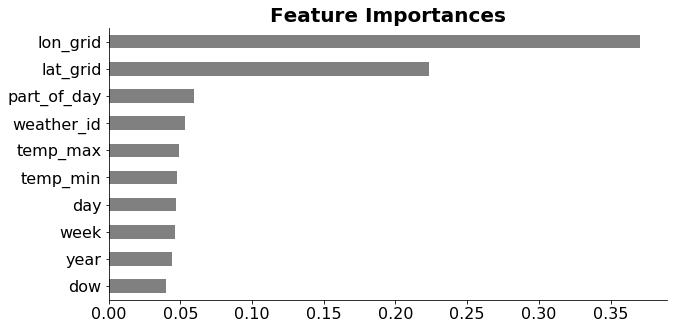

In [37]:
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
n = 10
fig, ax = plt.subplots(figsize=(10,n/2))
# ax.figure(figsize=(10,n/2))
plt.title('Feature Importances',
          fontsize=20,
          fontweight='bold')

ax.set_facecolor(color='none')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

importances.sort_values()[-n:].plot.barh(color='.5',
                                         fontsize=16
                                         );

# Partial Dependence Plot

In [53]:
from pdpbox.pdp import pdp_isolate, pdp_plot
plt.rcParams['figure.dpi'] = 150

feature = 'part_of_day'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)


(<Figure size 2250x1425 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1fd8685e148>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1fd9da02a48>})

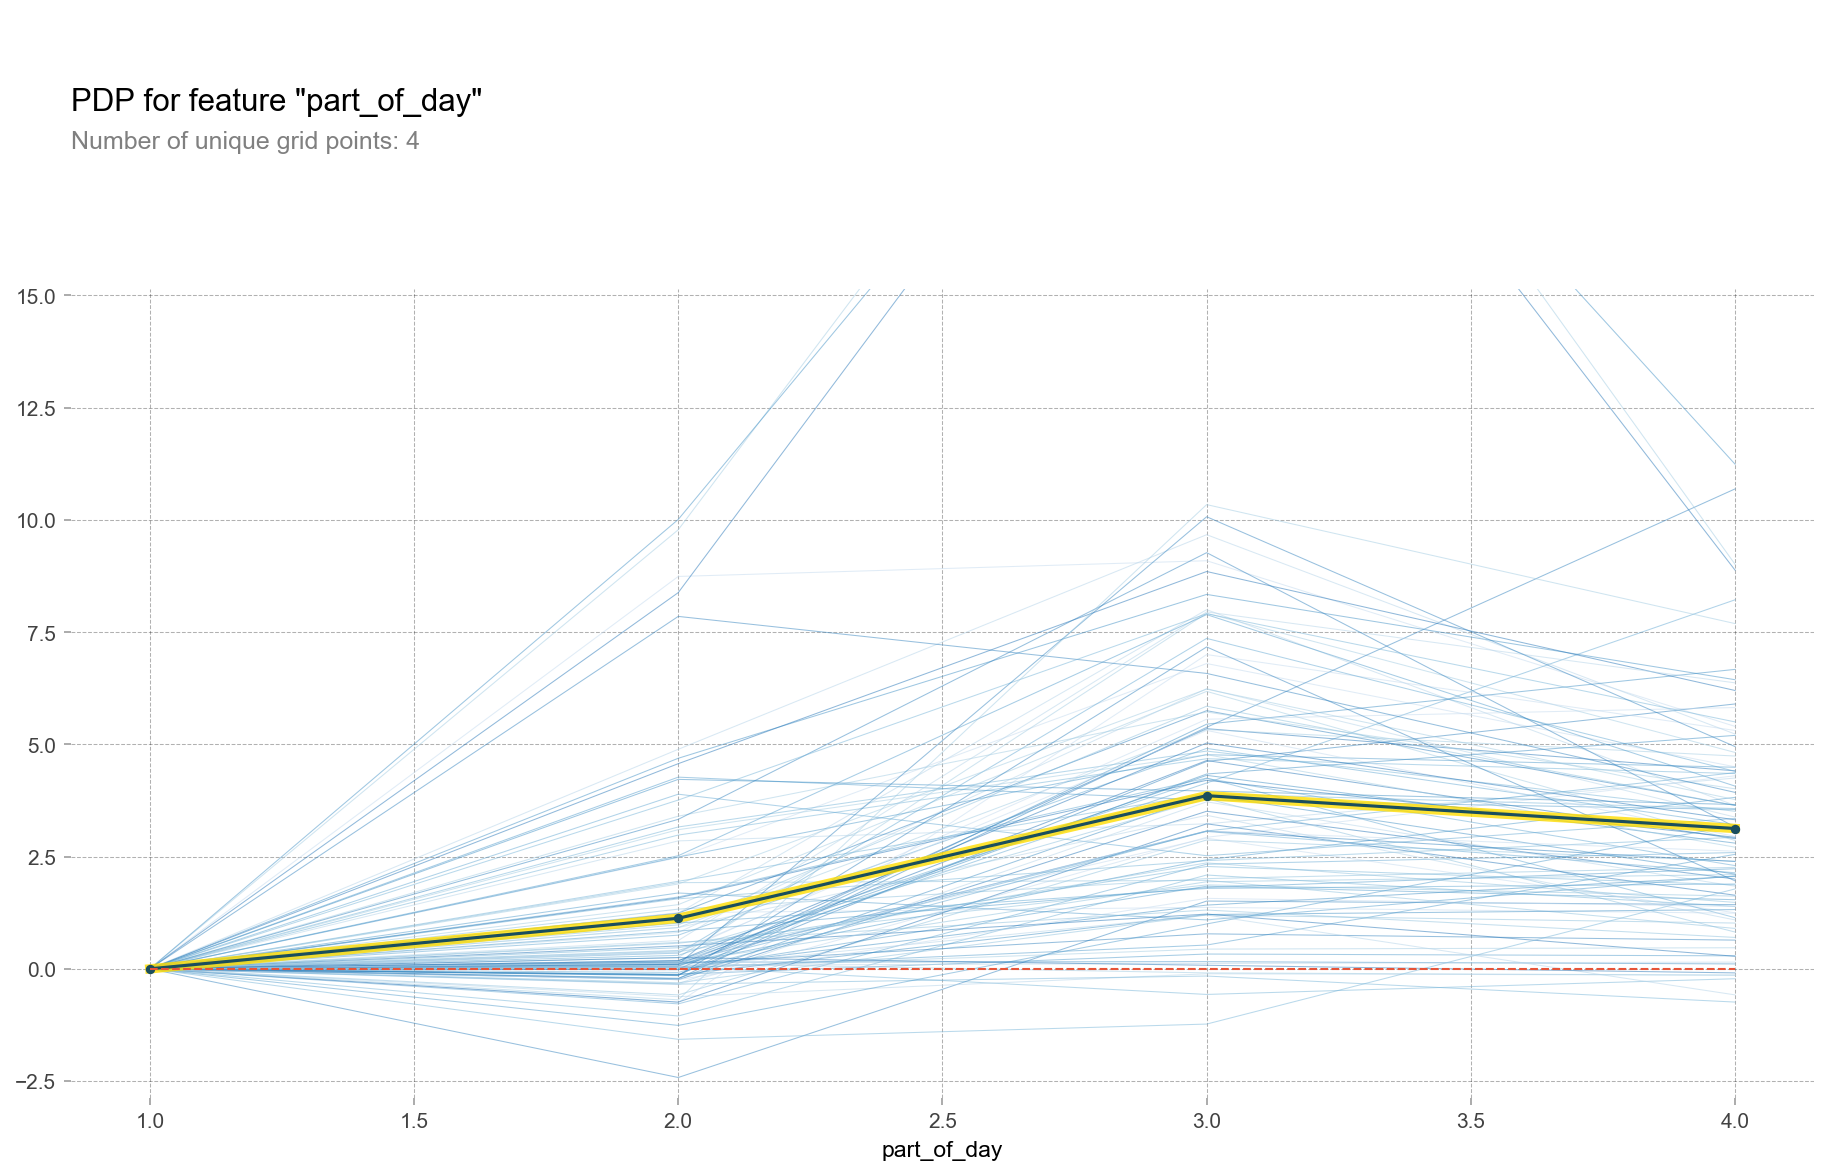

In [54]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)

# Plotting Predictions

In [55]:
pred_template = df.loc[((df.year == 2017) & (df.month == 8) & (df.day == 5))]
pred_template = pred_template[['part_of_day', 'lat_grid', 'lon_grid']]

In [60]:
def predict(date, weather, holiday):
    date = pd.to_datetime(date)
    year = date.year
    month = date.month
    day = date.day
    week = date.week
    dow = date.dayofweek
    
    df = pd.read_csv(r'C:\Users\btros\Detroit-911-Calls-Dash-App\assets\raw_csvs\pred_template.csv')
    df = df.drop(columns='Unnamed: 0')
    length = len(df)
    
    # Date
    df['year'] = [year]*length
    df['month'] = [month]*length
    df['day'] = [day]*length
    df['week'] = [week]*length
    df['dow'] = [dow]*length
    # Weather
    df['temp_min'] = [weather[0]]*length
    df['temp_max'] = [weather[1]]*length
    df['weather_id'] = [weather[2]]*length
    df['is_severe'] = [weather[3]]*length
    # holiday
    df['is_holiday'] = [holiday]*length
    
    
    
    
    preds = pipeline.predict(df)
    
    df['count'] = preds
    
    return df

In [59]:
train.head(1)

,year,month,day,dow,week,part_of_day,lat_grid,lon_grid,count,weather_id,severe,temp_min,temp_max,is_holiday
0,2016,9,20,1,38,1,5.0,3.0,1,800.5,0.0,61.661,70.169,0.0


In [61]:
pred_df = predict('20200515', [70, 65, 800, 0], 0)

In [62]:
grid = to_heatmap_format(pred_df)

In [64]:
grid

lon_grid,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
lat_grid,,,,,,,,,,,,,,,
0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,2.0,NaN,2.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN
4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,1.0,NaN,NaN
5.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,1.0
6.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,1.0,4.0,4.0,4.0,4.0,NaN
7.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0
8.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0


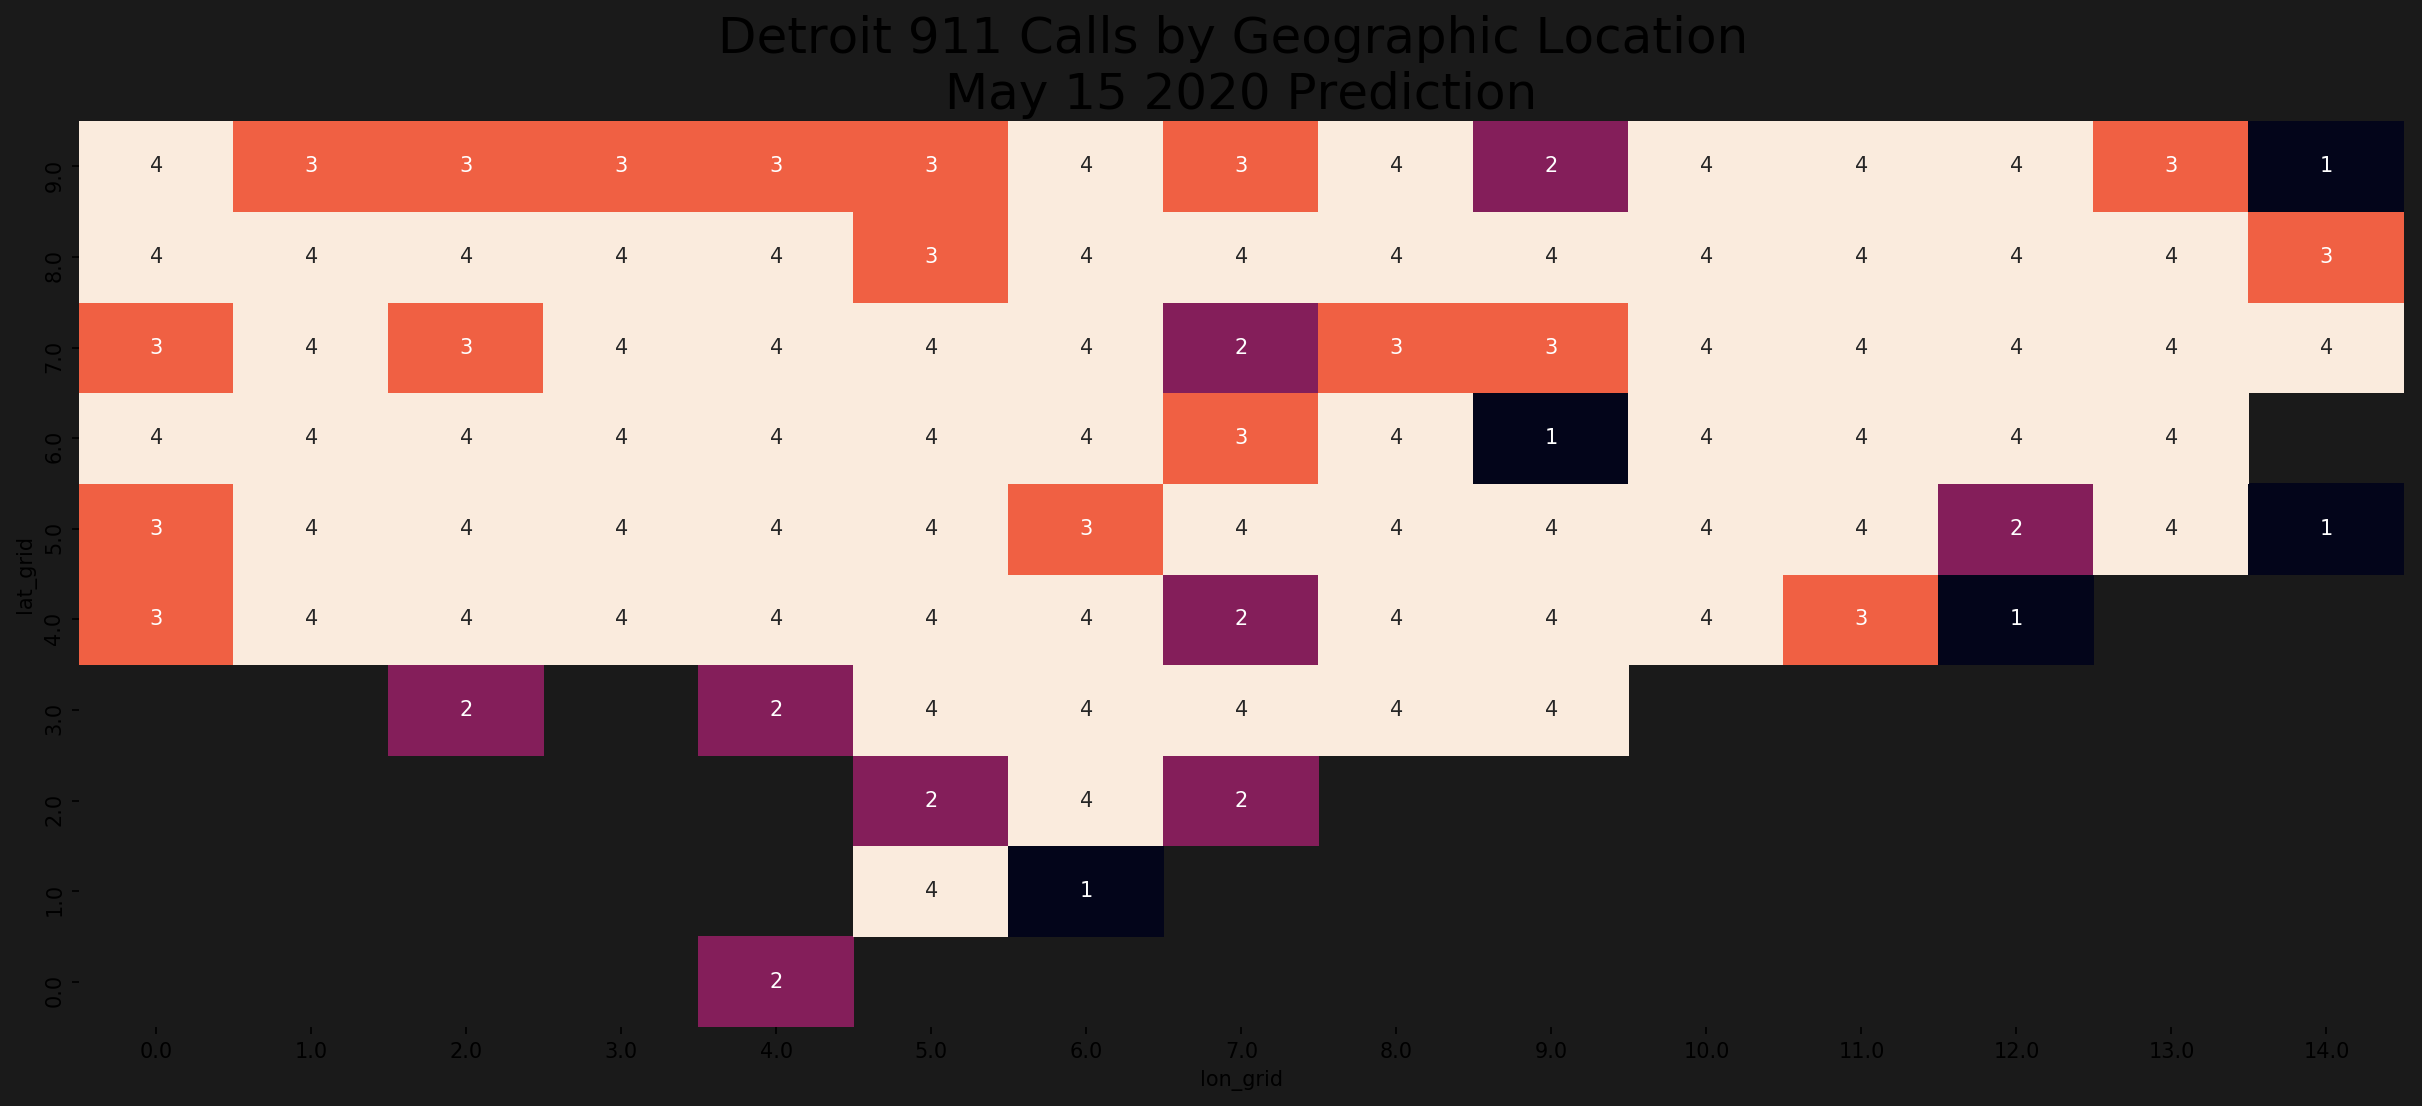

In [68]:
plot_calls_grid(grid)